## second level analysis

In [2]:
from os.path import join as opj
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.interfaces.spm import (OneSampleTTestDesign, EstimateModel,
                                   EstimateContrast, Threshold)
from nipype.interfaces.utility import IdentityInterface
from nipype import Workflow, Node
from nipype.interfaces.fsl import Info
from nipype.algorithms.misc import Gunzip
import os,json,glob,sys
import numpy
import nibabel
import nilearn.plotting
%matplotlib inline
import matplotlib.pyplot as plt

201008-09:42:44,254 nipype.utils WARNING:
	 A newer version (1.5.1) of nipy/nipype is available. You are using 1.5.0-rc1.post-dev


In [15]:
!pip install matplotlib==3.1.3

     |████████████████████████████████| 13.1 MB 3.5 MB/s eta 0:00:01
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.1
    Uninstalling matplotlib-3.2.1:
      Successfully uninstalled matplotlib-3.2.1


In [1]:
import matplotlib
print(matplotlib.__version__)

3.1.3


In [3]:
print(nilearn.__version__)

0.6.2


### check 1st level contrasts

In [4]:
from glob import glob
# spmT_images = glob('/output/first_level/1stLevel/sub-06/con*') # masked
spmT_images = glob('/output/first_level_nomask/1stLevel/sub-06/con*') # not masked
spmT_images

['/output/first_level_nomask/1stLevel/sub-06/con_0001.nii',
 '/output/first_level_nomask/1stLevel/sub-06/con_0004.nii',
 '/output/first_level_nomask/1stLevel/sub-06/con_0002.nii',
 '/output/first_level_nomask/1stLevel/sub-06/con_0003.nii',
 '/output/first_level_nomask/1stLevel/sub-06/con_0005.nii']

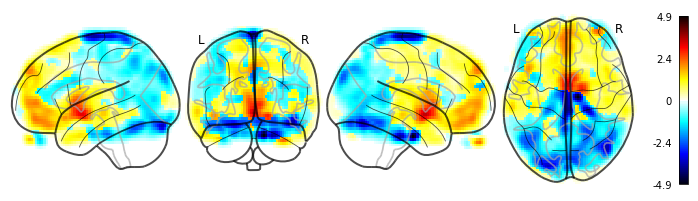

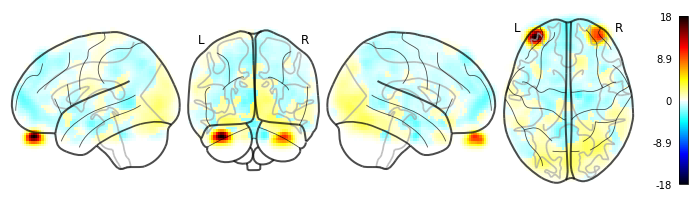

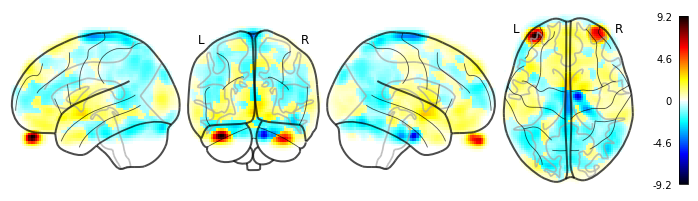

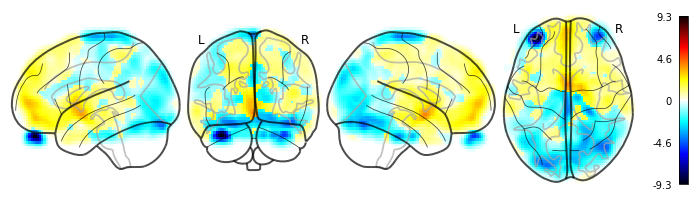

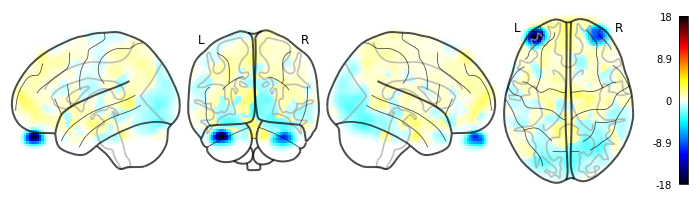

In [5]:
for con_image in spmT_images:
    nilearn.plotting.plot_glass_brain(nilearn.image.smooth_img(con_image, 8),
                                      display_mode='lyrz', colorbar=True, plot_abs=False)

### make group mask

In [6]:
from glob import glob
brainmasks = glob('/data/sub-*/func/*brain_mask.nii.gz')
print(brainmasks[21])

/data/sub-15/func/sub-15_task-tsl_run-3_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz


In [ ]:
# mean of all masks
mean_mask = nilearn.image.mean_img(brainmasks)
nilearn.plotting.plot_stat_map(mean_mask)

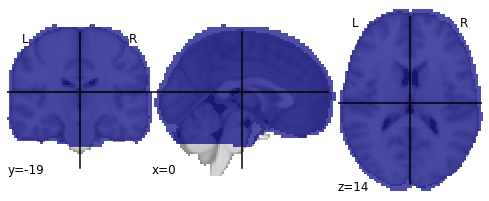

In [16]:
# binarised mask
group_mask = nilearn.image.math_img("a>=0.1", a=mean_mask)
nilearn.plotting.plot_roi(group_mask)

In [22]:
# saving group mask
group_mask.to_filename('/data/group_mask.nii.gz')

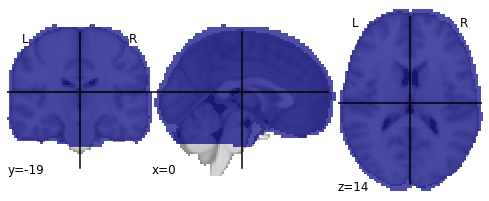

In [23]:
gm = '/data/group_mask.nii.gz'
nilearn.plotting.plot_roi(gm)

### define params

In [24]:
experiment_dir = '/output'
# output_dir = 'first_level'# masked
output_dir = 'first_level_nomask'# non mask
working_dir = 'workingdir'

# Which contrasts to use for the 2nd-level analysis
contrast_list = ['con_0001', 'con_0002', 'con_0003', 'con_0004', 'con_0005']

mask = '/data/group_mask.nii.gz'

### specify nodes

In [27]:
# Gunzip - unzip the mask image
gunzip = Node(Gunzip(in_file=mask), name="gunzip")

# OneSampleTTestDesign - creates one sample T-Test Design
onesamplettestdes = Node(OneSampleTTestDesign(),
                         name="onesampttestdes")

# EstimateModel - estimates the model
level2estimate = Node(EstimateModel(estimation_method={'Classical': 1}),
                      name="level2estimate")

# EstimateContrast - estimates group contrast
level2conestimate = Node(EstimateContrast(group_contrast=True),
                         name="level2conestimate")
cont1 = ['Group', 'T', ['mean'], [1]]
level2conestimate.inputs.contrasts = [cont1]

# Threshold - thresholds contrasts
level2thresh = Node(Threshold(contrast_index=1,
                              use_topo_fdr=True,
                              use_fwe_correction=False,
                              extent_threshold=0,
                              height_threshold=0.005,
                              height_threshold_type='p-value',
                              extent_fdr_p_threshold=0.05),
                    name="level2thresh")

### input/output stream

In [28]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['contrast_id']),
                  name="infosource")
infosource.iterables = [('contrast_id', contrast_list)]
#                         ('fwhm_id', fwhm)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
templates = {'cons': opj(experiment_dir, output_dir, '1stLevel', 'sub-*',
                         '{contrast_id}.nii')}
selectfiles = Node(SelectFiles(templates,
                               base_directory=experiment_dir,
                               sort_filelist=True),
                   name="selectfiles")

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

# Use the following DataSink output substitutions
substitutions = [('_contrast_id_', '')]
datasink.inputs.substitutions = substitutions

### specify workflow

In [7]:
# masked data in 1st level, run 2nd without mask

# Initiation of the 2nd-level analysis workflow
l2analysis = Workflow(name='spm_l2analysis')
l2analysis.base_dir = opj(experiment_dir, working_dir)

# Connect up the 2nd-level analysis components
l2analysis.connect([(infosource, selectfiles, [('contrast_id', 'contrast_id')]),
                    (selectfiles, onesamplettestdes, [('cons', 'in_files')]),
#                     (gunzip, onesamplettestdes, [('out_file',
#                                                   'explicit_mask_file')]),
                    (onesamplettestdes, level2estimate, [('spm_mat_file',
                                                          'spm_mat_file')]),
                    (level2estimate, level2conestimate, [('spm_mat_file',
                                                          'spm_mat_file'),
                                                         ('beta_images',
                                                          'beta_images'),
                                                         ('residual_image',
                                                          'residual_image')]),
                    (level2conestimate, level2thresh, [('spm_mat_file',
                                                        'spm_mat_file'),
                                                       ('spmT_images',
                                                        'stat_image'),
                                                       ]),
                    (level2conestimate, datasink, [('spm_mat_file',
                                                    '2ndLevel.@spm_mat'),
                                                   ('spmT_images',
                                                    '2ndLevel.@T'),
                                                   ('con_images',
                                                    '2ndLevel.@con')]),
                    (level2thresh, datasink, [('thresholded_map',
                                               '2ndLevel.@threshold')]),
                    ])

In [29]:
# unmasked preproc and 1st level, using mask in 2nd level
# Initiation of the 2nd-level analysis workflow
l2analysis = Workflow(name='spm_l2analysis')
l2analysis.base_dir = opj(experiment_dir, working_dir)

# Connect up the 2nd-level analysis components
l2analysis.connect([(infosource, selectfiles, [('contrast_id', 'contrast_id')]),
                    (selectfiles, onesamplettestdes, [('cons', 'in_files')]),
                    (gunzip, onesamplettestdes, [('out_file',
                                                  'explicit_mask_file')]),
                    (onesamplettestdes, level2estimate, [('spm_mat_file',
                                                          'spm_mat_file')]),
                    (level2estimate, level2conestimate, [('spm_mat_file',
                                                          'spm_mat_file'),
                                                         ('beta_images',
                                                          'beta_images'),
                                                         ('residual_image',
                                                          'residual_image')]),
                    (level2conestimate, level2thresh, [('spm_mat_file',
                                                        'spm_mat_file'),
                                                       ('spmT_images',
                                                        'stat_image'),
                                                       ]),
                    (level2conestimate, datasink, [('spm_mat_file',
                                                    '2ndLevel.@spm_mat'),
                                                   ('spmT_images',
                                                    '2ndLevel.@T'),
                                                   ('con_images',
                                                    '2ndLevel.@con')]),
                    (level2thresh, datasink, [('thresholded_map',
                                               '2ndLevel.@threshold')]),
                    ])

### run workflow

In [30]:
l2analysis.run('MultiProc', plugin_args={'n_procs': 4})

201008-09:26:40,889 nipype.workflow INFO:
	 Workflow spm_l2analysis settings: ['check', 'execution', 'logging', 'monitoring']
201008-09:26:41,40 nipype.workflow INFO:
	 Running in parallel.
201008-09:26:41,77 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 6 jobs ready. Free memory (GB): 14.07/14.07, Free processors: 4/4.
201008-09:26:41,441 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.selectfiles" in "/output/workingdir/spm_l2analysis/_contrast_id_con_0004/selectfiles".
201008-09:26:41,454 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.selectfiles" in "/output/workingdir/spm_l2analysis/_contrast_id_con_0003/selectfiles".
201008-09:26:41,440 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.selectfiles" in "/output/workingdir/spm_l2analysis/_contrast_id_con_0005/selectfiles".
201008-09:26:41,483 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")201008-09:26:41,466 nipype.workflow INFO:
	 [Node] Setting-up "

### visualise results

comparing different masking

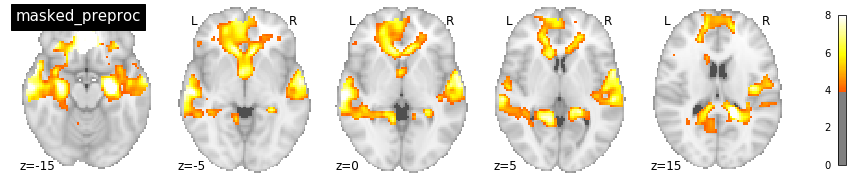

In [8]:
nilearn.plotting.plot_stat_map(
    '/output/first_level/2ndLevel/con_0001/spmT_0001_thr.nii', title='masked_preproc',
    threshold=4, vmax=8, display_mode='z', cut_coords=(-15, -5, 0, 5, 15),
    colorbar=True);

looking at different contrasts

In [29]:
smap = '/output/first_level_nomask/2ndLevel/con_0001/spmT_0001_thr.nii'
ttl = 'All pain'

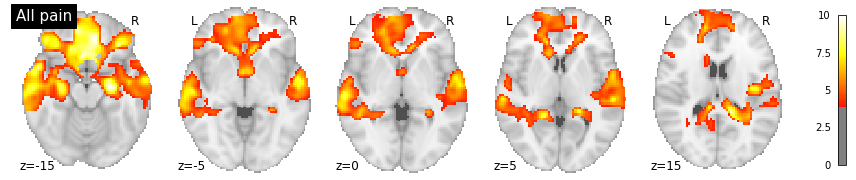

In [33]:
all_pain_z = nilearn.plotting.plot_stat_map(
    smap, title=ttl,
    threshold=4, vmax=10, display_mode='z', cut_coords=(-15, -5, 0, 5, 15),
    colorbar=True);
all_pain_z.savefig('./figs/all_pain_z.pdf')

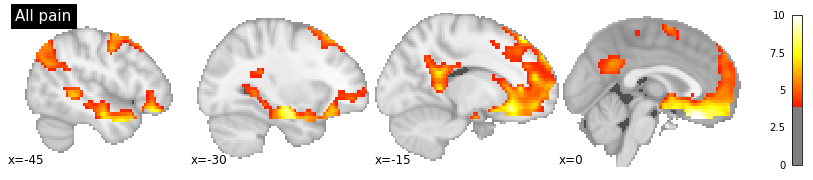

In [34]:
all_pain_x = nilearn.plotting.plot_stat_map(
    smap, title=ttl,
    threshold=4, vmax=10, display_mode='x', cut_coords=(-45, -30, -15, 0),
    colorbar=True);
all_pain_x.savefig('./figs/all_pain_x.pdf')

In [36]:
# smap = '/output/first_level/2ndLevel/con_0004/spmT_0001_thr.nii'
smap = '/output/first_level_nomask/2ndLevel/con_0004/spmT_0001_thr.nii'
ttl = 'High>Low pain'

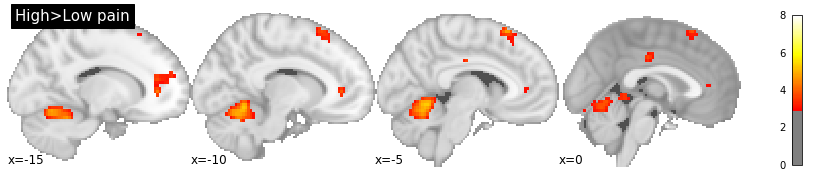

In [37]:
hl_x = nilearn.plotting.plot_stat_map(
    smap, title=ttl,
    threshold=3, vmax=8, display_mode='x', cut_coords=(-15, -10, -5, 0),
    colorbar=True);
hl_x.savefig('./figs/high_minus_low_x.pdf')

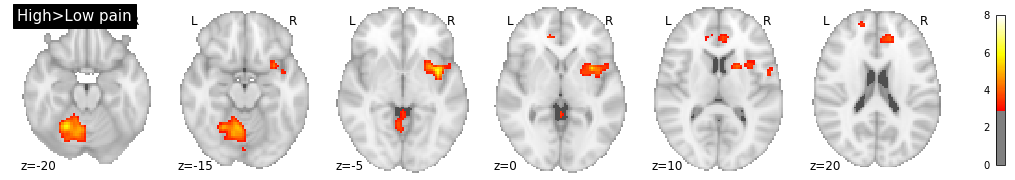

In [38]:
hl_z = nilearn.plotting.plot_stat_map(
    smap, title=ttl,
    threshold=3, vmax=8, display_mode='z', cut_coords=(-20, -15, -5, 0, 10, 20),
    colorbar=True);
hl_z.savefig('./figs/high_minus_low_z.pdf')

### visualise workflow

In [10]:
# Create 1st-level analysis output graph
l2analysis.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(l2analysis.base_dir, 'spm_l2analysis', 'graph.png'))